# Semi-supervised learning with a Graph-convolutional network

We test the GCN approach ([Kipf & Welling, 2016, “Semi-Supervised Classification with Graph Convolutional Networks”](http://arxiv.org/abs/1609.02907)) on random graphs and create a visualisation to understand what is going on.

You can jump directly to [Test random graphs](#Test-random-graphs), the rest is setup and viz code.

### Setup and imports

In [1]:
import time
import itertools

import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.patches import Wedge, Circle
from matplotlib.text import Text
%matplotlib inline
import seaborn as sb
from IPython.display import HTML, display

from gcn.models import GCN
from gcn import utils as gcn_utils

#mpl.rc('animation', embed_limit=50 * 1024 * 1024) # In bytes; default limit in 20MB
VID = 'animations/l={l}-k={k}-p_inner={p_inner}-p_outer={p_outer}-f_mult={f_mult}-f_sigma={f_sigma}.mp4'

### Network drawing routines

In [2]:
BORDER_PROP = .2
RADIUS_GAP = .2
THETA_GAP = .05

def inner_repeat(it, n):
    return itertools.chain(*zip(*itertools.tee(it, n)))

def nodes_patches(layout, labels, training_nodes=[], radius=.04):
    titles, xys = zip(*sorted(layout.items()))
    
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette_border = np.array(sb.color_palette(n_colors=labels.shape[1]))
    palette_circle = np.array(sb.color_palette(n_colors=labels.shape[1]))

    # Create wedges
    wedges = []
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for i, (xy, theta1, theta2) in enumerate(zip(inner_repeat(xys, labels.shape[1]),
                                                 thetas1.flat, thetas2.flat)):
        wedges.append(Wedge(xy, radius,
                            theta1 * 360, theta2 * 360,
                            width=BORDER_PROP * radius,
                            color=palette_border[i % labels.shape[1]]))
    
    # Create central circles and titles
    circles = []
    texts = []
    color_predictions = palette_circle[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for xy, color, title in zip(xys, color_predictions, titles):
        circles.append(Circle(xy, radius * (1 - BORDER_PROP - RADIUS_GAP), color=color))
        texts.append(Text(x=xy[0], y=xy[1], text=str(title),
                          va='center', ha='center',
                          color='white', # if np.mean(color) >= .5 else 'black',
                          #fontsize=radius * 100)
                          ))
    
    return wedges + circles, texts

def update_nodes_patches(patches, labels, training_nodes=[]):
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette = np.array(sb.color_palette(n_colors=labels.shape[1]))
    
    # Extract wedges and circles
    wedges = list(filter(lambda p: isinstance(p, Wedge), patches))
    assert len(wedges) == np.prod(labels.shape)
    circles = list(filter(lambda p: isinstance(p, Circle), patches))
    assert len(circles) == labels.shape[0]
    
    # Update wedges
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for theta1, theta2, wedge in zip(thetas1.flat, thetas2.flat, wedges):
        wedge.set_theta1(theta1 * 360)
        wedge.set_theta2(theta2 * 360)
    
    # Update circles
    color_predictions = palette[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for circle, color in zip(circles, color_predictions):
        circle.set_color(color)

_network_layouts = {}
def draw_network(g, labels=None, training_nodes=[], ax=None, relayout=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.figure
    
    if relayout or g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if labels is None:
        assert len(training_nodes) == 0
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_patches = None
        edge_collection = None
        text_items = None
    else:
        # Plot nodes, edges and labels
        node_patches, text_items = nodes_patches(layout, labels, training_nodes=training_nodes)
        for artist in itertools.chain(node_patches, text_items):
            ax.add_artist(artist)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, edge_color='grey', ax=ax)
        
        # Add the colorbar
        #color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lmin, vmax=lmax))
        #color_sm.set_array([])
        #fig.colorbar(color_sm)
    
    xs, ys = np.array(list(layout.values())).T
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), aspect='equal')
    return (fig, ax), (node_patches, edge_collection, text_items)

### Try out feature randomisation

In [3]:
def feature_sample(mode, scale=.2, size=None):
    #α = alpha
    #β = (α - 1) / mode - α + 2
    #return np.random.beta(α, β, size=size)
    return np.random.normal(mode, scale, size=size)

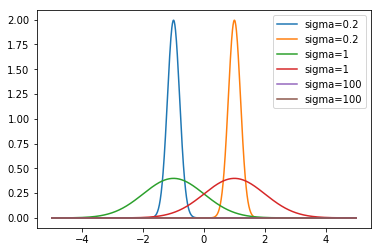

In [4]:
for sigma in [.2, 1, 100]:
    x = np.linspace(-5, 5, 1000)
    plt.plot(x, np.c_[scipy.stats.norm.pdf(x, -1, sigma), scipy.stats.norm.pdf(x, 1, sigma)],
             label='sigma={}'.format(sigma))
    #plt.hist(feature_sample(1, i, size=1000), normed=True, bins=50, alpha=.6)
plt.legend()

### GCN training setup

#### Initial setup

Base options for the model

In [5]:
flags = tf.app.flags
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0, #0.5,
                   'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0, #5e-4,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')

In [6]:
def initialise_arrays(labels, mult, sigma, training_nodes):
    # Generate initial noised features
    features_noise = np.stack([np.concatenate([feature_sample(v, scale=sigma, size=mult)
                                               for v in label_values])
                               for label_values in labels])
    features = gcn_utils.preprocess_features(sp.sparse.lil_matrix(features_noise))

    # Generate training and validation arrays
    train_mask = gcn_utils.sample_mask(training_nodes, labels.shape[0])
    val_mask = np.logical_not(train_mask)

    labels_train = np.zeros(labels.shape)
    labels_val = np.zeros(labels.shape)

    labels_train[train_mask, :] = labels[train_mask, :]
    labels_val[val_mask, :] = labels[val_mask, :]
    
    return {
        'features': features,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'labels': labels,
        'labels_train': labels_train,
        'labels_val': labels_val,
    }

In [7]:
def initialise_model_session(g, labels, mult, sigma, training_nodes):
    arrays = initialise_arrays(labels, mult, sigma, training_nodes)
    
    # Finish parameterising the model
    support = [gcn_utils.preprocess_adj(nx.adjacency_matrix(g))]
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(len(support))],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(arrays['features'][2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, arrays['labels_train'].shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }
    arrays['support'] = support
    arrays['placeholders'] = placeholders
    
    model = GCN(placeholders, input_dim=arrays['features'][2][1], logging=True)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    return model, arrays, session

In [8]:
def evaluate_model(model, arrays, session):
    t_test = time.time()
    feed_dict_val = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_val'], arrays['val_mask'],
                                                  arrays['placeholders'])
    outs_val = session.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

def model_predict(model, arrays, session):
    feed_dict_pred = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                   arrays['labels'], np.ones(arrays['labels'].shape[0]),
                                                   arrays['placeholders'])
    return session.run(model.predict(), feed_dict=feed_dict_pred)

#### Model training

In [38]:
def legend_text(epoch, t, train_loss, train_acc, val_loss, val_acc):
    return ("epoch: {:4d} time={:.5f}\n"
            "train_loss={:.5f} train_acc={:.5f}\n"
            "val_loss={:.5f} val_acc={:.5f}\n").format(epoch, time.time() - t,
                                                       train_loss, train_acc, val_loss, val_acc)

def build_train_animation(glk, labels, mult, sigma,
                          training_nodes=None, community_training_pct=.2,
                          log=True):
    if isinstance(glk, tuple):
        g, l, k = glk
    else:
        g = glk
    if training_nodes is None:
        trains_per_cty = int(np.round(k * community_training_pct))
        training_nodes = np.concatenate([np.random.choice(range(c * k, (c + 1) * k),
                                                          trains_per_cty, replace=False)
                                         for c in range(l)])
    
    # Get the model
    model, arrays, session = initialise_model_session(g, labels, mult, sigma, training_nodes)
    
    # Prepare plotting
    (fig, ax), (node_patches, _, _) = draw_network(g, labels=labels,
                                                   training_nodes=np.where(arrays['train_mask'])[0])
    legend = ax.text(.5, 1, legend_text(0, 0, 0, 0, 0, 0),
                     ha='center', va='bottom', transform=ax.transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    def init_plot():
        legend.set_text(legend_text(0, 0, 0, 0, 0, 0))
        return node_patches + [legend]

    cost_val = []
    def train_step(frame):
        t = time.time()

        feed_dict = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
        feed_dict.update({arrays['placeholders']['dropout']: flags.FLAGS.dropout})

        outs = session.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
        cost, acc, duration = evaluate_model(model, arrays, session)
        cost_val.append(cost)

        if log:
            print("Epoch:", '%04d' % (frame + 1), "train_loss={:.5f}".format(outs[1]),
                  "train_acc={:.5f}".format(outs[2]), "val_loss={:.5f}".format(cost),
                  "val_acc={:.5f}".format(acc), "time={:.5f}".format(time.time() - t))
        
        legend.set_text(legend_text(frame, t, outs[1], outs[2], cost, acc))
        
        preds = model_predict(model, arrays, session)
        update_nodes_patches(node_patches, preds, training_nodes=np.where(arrays['train_mask'])[0])

        return node_patches + [legend]

    def model_frames():
        counter = 0
        while True:
            if (counter > flags.FLAGS.early_stopping and
                    cost_val[-1] > np.mean(cost_val[-(flags.FLAGS.early_stopping+1):-1])):
                if log:
                    print("Early stopping.")
                return
            else:
                yield counter
                counter += 1

    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=flags.FLAGS.epochs,
                                       frames=model_frames(),
                                       repeat=False)
    plt.close()
    return anim, (model, arrays, session)

### Test random graphs

We test the model on small random graphs to understand what's going on.

Each graph is created with a structure corresponding to $l$ communities (which appear more or less clearly). The "real" node labels are then $l$-dimensional vectors $Y$. E.g. for 3 communities, the label $Y_i$ for node $i$ can be `[1, 0, 0]` (community 0), `[0, 1, 0]` (community 1), `[0, 0, 1]` (community 2).

We then give node $i$ features $X_i$ which are a noisy version of the labels: $X_{i, j} \sim Y_{i, j} + \mathcal{N}(0, \sigma^2)$ for $j \in \{1, \dots, l\}$. The GCN takes the $X_i$ as input and learns to transform those; it is trained to mimick the $Y_i$ on a subset of the graph, i.e. it creates label predictions $Z_i = GCN(X_i)$ which should be as close to the $Y_i$ as possible. Note that $\sum_j Z_{i,j} = 1$, i.e. each coordinate of a predicted label is a probability of belonging to a community.

For each graph there are two or three cells:

* We first plot the "real" labels on which we train
* then we create an animation of the tranining process which is saved to an external file (and not shown in the notebook); the last line of the "train" cell indicates where the animation file is saved
* Sometimes we show individual predicted labels for specific nodes when useful

**Visualisation for a set of labels $Y_i$ or predictions $Z_i$:**

* Node color indicates the current inferred community of the node, defined as $\operatorname{argmax}_j Z_{i, j}$
* Node border color indicates the inferred probability of belonging to the "real" community, i.e. $Z_{i, \operatorname{argmax}_j Y_{i, j}}$
* Training nodes appear in black in the training animations


**Possible random graphs generators:**

* [Planted Partition](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.planted_partition_graph.html#networkx.generators.community.planted_partition_graph): all graphs below are made using this, or connecting two such graphs
* [Lancichinetti–Fortunato–Radicchi benchmark](https://en.wikipedia.org/wiki/Lancichinetti%E2%80%93Fortunato%E2%80%93Radicchi_benchmark) (we don't use this here)

#### Two large communites with an oddball in the middle, which we assign to a third community. Initial feature noise $\sigma = .2$

The animation shows first that since we don't train on the oddball, its community is not recovered at the end.

In fact, the weighing in the GCN is such that nodes that have fewer neighbours contribute *more* to their own neighbours' feature. At the time of writing (though this could change if we re-run the cell and get a different random graph), the oddball is connected to 4 nodes in each large communities; the green community should win because the green nodes that touch the oddball have fewer edges than the turquoise nodes touching the oddball, therefore their contribution is greater to the oddball's predicted label.

Running this animation several times on different random graphs confirms this intuition. Also note, in the cell below the training, the label prediction for the oddball node: it is not clear-cut, and instead reflects the slight preference for community 2 (green). Community 1 (the oddball community) is forgotten, with a probabiltiy of .006.

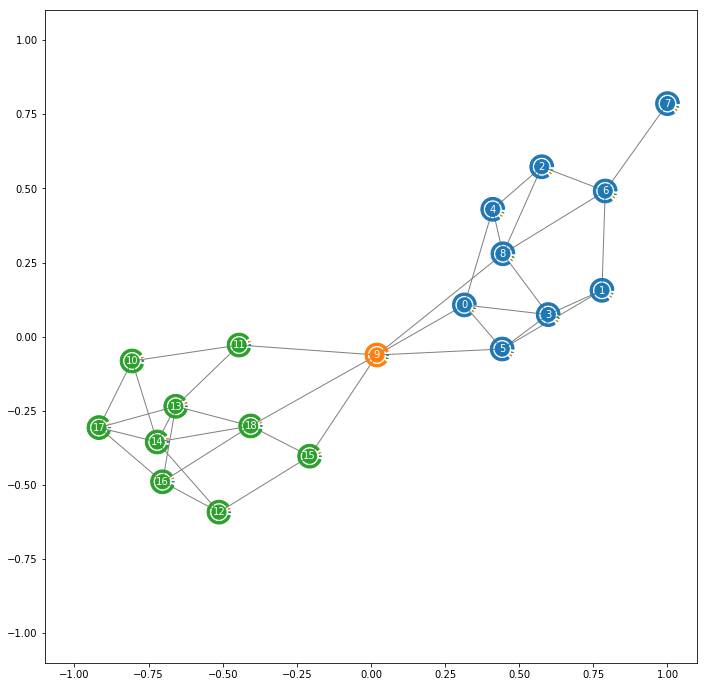

In [20]:
# Parameters
l1, l2, li = (10, 10, 1)
p_inner = .4
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [21]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.42674 train_acc=0.00000 val_loss=1.31071 val_acc=0.05882 time=0.02054
Epoch: 0002 train_loss=1.38193 train_acc=0.00000 val_loss=1.27830 val_acc=0.05882 time=0.00144
Epoch: 0003 train_loss=1.33872 train_acc=0.00000 val_loss=1.24688 val_acc=0.05882 time=0.00148
Epoch: 0004 train_loss=1.29675 train_acc=0.00000 val_loss=1.21671 val_acc=0.05882 time=0.00149
Epoch: 0005 train_loss=1.25643 train_acc=0.00000 val_loss=1.18774 val_acc=0.05882 time=0.00177
Epoch: 0006 train_loss=1.21778 train_acc=0.00000 val_loss=1.16002 val_acc=0.05882 time=0.00138
Epoch: 0007 train_loss=1.18072 train_acc=0.00000 val_loss=1.13351 val_acc=0.11765 time=0.00143
Epoch: 0008 train_loss=1.14505 train_acc=0.00000 val_loss=1.10812 val_acc=0.23529 time=0.00168
Epoch: 0009 train_loss=1.11089 train_acc=0.00000 val_loss=1.08367 val_acc=0.47059 time=0.00140
Epoch: 0010 train_loss=1.07807 train_acc=0.50000 val_loss=1.06027 val_acc=0.47059 time=0.00421
Epoch: 0011 train_loss=1.04658 train_acc=0.50000 v

Epoch: 0089 train_loss=0.02463 train_acc=1.00000 val_loss=0.27107 val_acc=0.94118 time=0.00185
Epoch: 0090 train_loss=0.02379 train_acc=1.00000 val_loss=0.27098 val_acc=0.94118 time=0.00197
Epoch: 0091 train_loss=0.02300 train_acc=1.00000 val_loss=0.27091 val_acc=0.94118 time=0.00175
Epoch: 0092 train_loss=0.02226 train_acc=1.00000 val_loss=0.27086 val_acc=0.94118 time=0.00138
Epoch: 0093 train_loss=0.02156 train_acc=1.00000 val_loss=0.27083 val_acc=0.94118 time=0.00155
Epoch: 0094 train_loss=0.02090 train_acc=1.00000 val_loss=0.27082 val_acc=0.94118 time=0.00136
Epoch: 0095 train_loss=0.02027 train_acc=1.00000 val_loss=0.27082 val_acc=0.94118 time=0.00140
Epoch: 0096 train_loss=0.01967 train_acc=1.00000 val_loss=0.27083 val_acc=0.94118 time=0.00139
Epoch: 0097 train_loss=0.01911 train_acc=1.00000 val_loss=0.27086 val_acc=0.94118 time=0.00145
Epoch: 0098 train_loss=0.01857 train_acc=1.00000 val_loss=0.27090 val_acc=0.94118 time=0.00144
Epoch: 0099 train_loss=0.01807 train_acc=1.00000 v

#### Two communities that largely overlap, creating several oddballs in the middle which we assign to a third community; $\sigma = .2$

This is an extension of the previous graph to several oddballs, with training only on the main communities and not on the oddballs.

The reasoning is the same: the oddball community is lost since we don't train on it, and each oddball node acquires the label given by its neighbours with lowest degree (provided it has the same number of neighbours of each competing community, otherwise the community with most touching neighbours is likely to win).

The cell below the training shows the predictions for the oddballs, which confirm the intuitions.

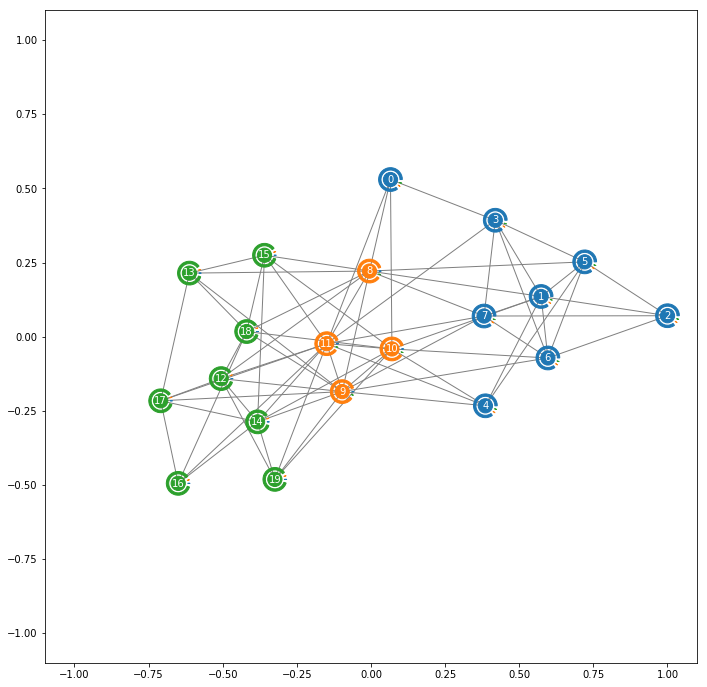

In [23]:
# Parameters
l1, l2, li = (12, 12, 4)
p_inner = .6
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [24]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.19161 train_acc=0.00000 val_loss=1.03612 val_acc=0.61111 time=0.02400
Epoch: 0002 train_loss=1.16785 train_acc=0.50000 val_loss=1.01573 val_acc=0.61111 time=0.00181
Epoch: 0003 train_loss=1.14457 train_acc=0.50000 val_loss=0.99607 val_acc=0.61111 time=0.00909
Epoch: 0004 train_loss=1.12205 train_acc=0.50000 val_loss=0.97711 val_acc=0.50000 time=0.00145
Epoch: 0005 train_loss=1.09995 train_acc=0.50000 val_loss=0.95876 val_acc=0.50000 time=0.00177
Epoch: 0006 train_loss=1.07816 train_acc=0.50000 val_loss=0.94097 val_acc=0.44444 time=0.00143
Epoch: 0007 train_loss=1.05667 train_acc=0.50000 val_loss=0.92364 val_acc=0.38889 time=0.00198
Epoch: 0008 train_loss=1.03544 train_acc=0.50000 val_loss=0.90708 val_acc=0.38889 time=0.00199
Epoch: 0009 train_loss=1.01504 train_acc=0.50000 val_loss=0.89117 val_acc=0.38889 time=0.00307
Epoch: 0010 train_loss=0.99522 train_acc=0.50000 val_loss=0.87582 val_acc=0.38889 time=0.00182
Epoch: 0011 train_loss=0.97547 train_acc=0.50000 v

#### Two communities that largely overlap, creating several oddballs in the middle which belong feature-wise to one or the other community; $\sigma = .2$

TODO: comment

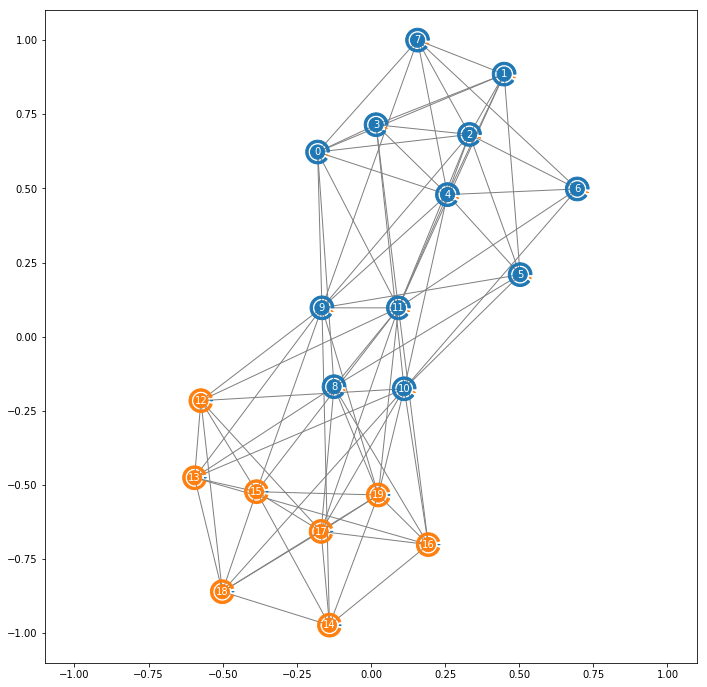

In [25]:
# Parameters
l1, l2, li = (12, 12, 4)
p_inner = .6
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 2))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 0] = 1
labels[l1:l1 + l2 - li, 1] = 1
draw_network(g, labels=labels);

In [26]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.57023 train_acc=1.00000 val_loss=0.62526 val_acc=0.72222 time=0.02550
Epoch: 0002 train_loss=0.55465 train_acc=1.00000 val_loss=0.61215 val_acc=0.72222 time=0.00140
Epoch: 0003 train_loss=0.53944 train_acc=1.00000 val_loss=0.59947 val_acc=0.77778 time=0.00187
Epoch: 0004 train_loss=0.52448 train_acc=1.00000 val_loss=0.58741 val_acc=0.77778 time=0.00163
Epoch: 0005 train_loss=0.50989 train_acc=1.00000 val_loss=0.57599 val_acc=0.77778 time=0.00281
Epoch: 0006 train_loss=0.49565 train_acc=1.00000 val_loss=0.56510 val_acc=0.77778 time=0.00173
Epoch: 0007 train_loss=0.48149 train_acc=1.00000 val_loss=0.55465 val_acc=0.77778 time=0.00181
Epoch: 0008 train_loss=0.46731 train_acc=1.00000 val_loss=0.54439 val_acc=0.77778 time=0.00168
Epoch: 0009 train_loss=0.45300 train_acc=1.00000 val_loss=0.53426 val_acc=0.77778 time=0.00220
Epoch: 0010 train_loss=0.43832 train_acc=1.00000 val_loss=0.52427 val_acc=0.77778 time=0.00145
Epoch: 0011 train_loss=0.42332 train_acc=1.00000 v

Epoch: 0088 train_loss=0.01104 train_acc=1.00000 val_loss=0.33969 val_acc=0.77778 time=0.00189
Epoch: 0089 train_loss=0.01078 train_acc=1.00000 val_loss=0.33978 val_acc=0.77778 time=0.00137
Early stopping.
Animation saved to 'animations/l=12|12|4-k=2-p_inner=0.6-p_outer=0-f_mult=1-f_sigma=0.2.mp4'


#### Two feature communities in a clique; $\sigma = .2$

TODO: comment

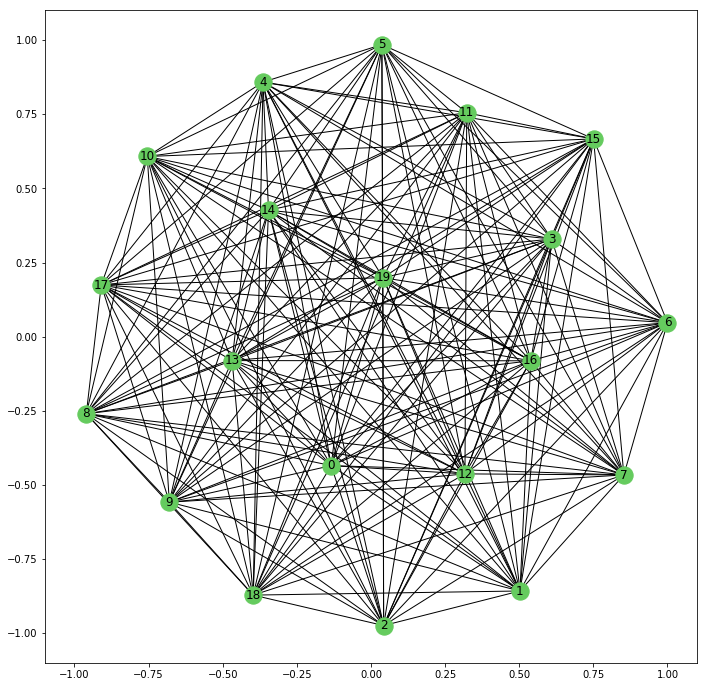

In [27]:
# Parameters
l = 1
k = 20
p_inner = 1
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
draw_network(g);

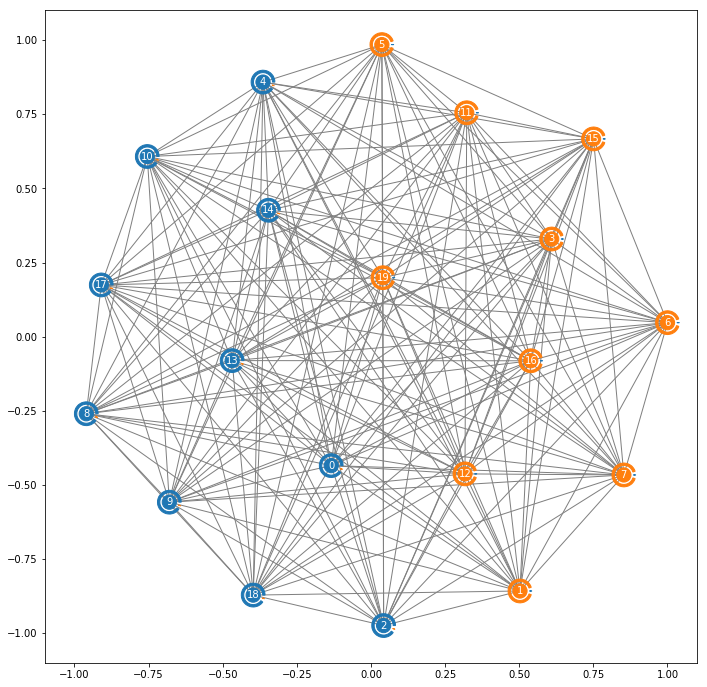

In [29]:
labels = np.zeros((l * k, 2))
c0 = [4, 14, 10, 17, 13, 8, 9, 18, 0, 2]
labels[c0, 0] = 1
labels[list(set(range(20)).difference(c0)), 1] = 1
draw_network(g, labels=labels);

In [30]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.64859 train_acc=0.75000 val_loss=0.71781 val_acc=0.43750 time=0.02811
Epoch: 0002 train_loss=0.63660 train_acc=0.75000 val_loss=0.72618 val_acc=0.43750 time=0.00254
Epoch: 0003 train_loss=0.62554 train_acc=0.75000 val_loss=0.73562 val_acc=0.43750 time=0.00171
Epoch: 0004 train_loss=0.61532 train_acc=0.75000 val_loss=0.74624 val_acc=0.43750 time=0.00147
Epoch: 0005 train_loss=0.60586 train_acc=0.75000 val_loss=0.75810 val_acc=0.43750 time=0.00153
Epoch: 0006 train_loss=0.59721 train_acc=0.75000 val_loss=0.77125 val_acc=0.43750 time=0.00143
Epoch: 0007 train_loss=0.58942 train_acc=0.75000 val_loss=0.78570 val_acc=0.43750 time=0.00259
Epoch: 0008 train_loss=0.58255 train_acc=0.75000 val_loss=0.80143 val_acc=0.43750 time=0.00150
Epoch: 0009 train_loss=0.57665 train_acc=0.75000 val_loss=0.81838 val_acc=0.43750 time=0.00150
Epoch: 0010 train_loss=0.57176 train_acc=0.75000 val_loss=0.83644 val_acc=0.43750 time=0.00147
Epoch: 0011 train_loss=0.56792 train_acc=0.75000 v

#### Two feature communities in a near-clique; $\sigma = .2$

TODO: comment

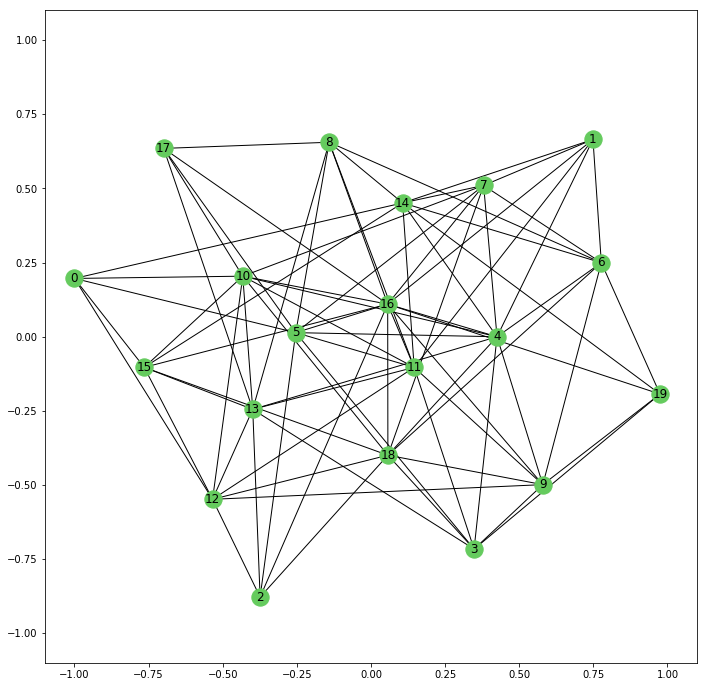

In [33]:
# Parameters
l = 1
k = 20
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
draw_network(g);

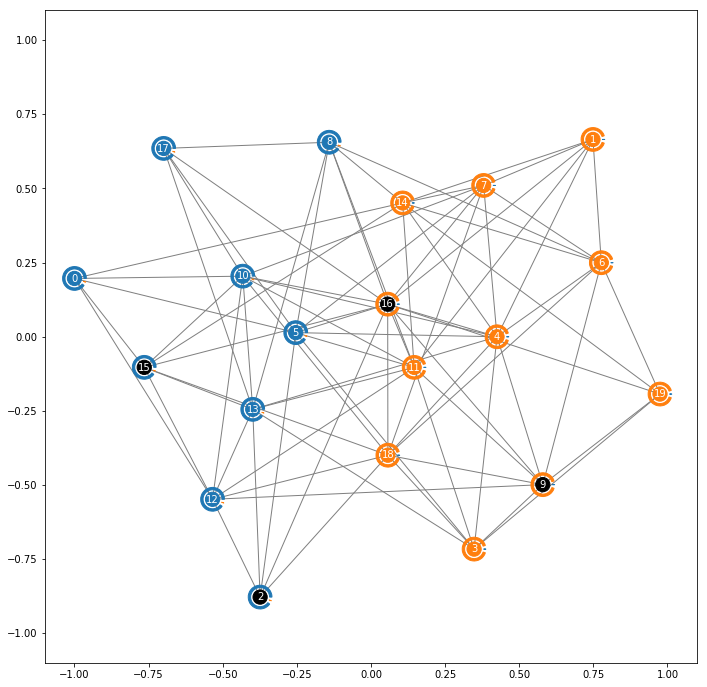

In [40]:
labels = np.zeros((l * k, 2))
c0 = [0, 17, 15, 10, 12, 13, 2, 5, 8]
training_nodes = [15, 2, 9, 16]
labels[c0, 0] = 1
labels[list(set(range(20)).difference(c0)), 1] = 1
draw_network(g, labels=labels, training_nodes=training_nodes);

In [41]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.68984 train_acc=0.50000 val_loss=0.68097 val_acc=0.43750 time=0.03598
Epoch: 0002 train_loss=0.68150 train_acc=0.50000 val_loss=0.67172 val_acc=0.50000 time=0.00205
Epoch: 0003 train_loss=0.67323 train_acc=0.50000 val_loss=0.66259 val_acc=0.62500 time=0.00219
Epoch: 0004 train_loss=0.66503 train_acc=0.50000 val_loss=0.65358 val_acc=0.81250 time=0.00192
Epoch: 0005 train_loss=0.65680 train_acc=0.75000 val_loss=0.64466 val_acc=0.87500 time=0.00156
Epoch: 0006 train_loss=0.64859 train_acc=0.75000 val_loss=0.63588 val_acc=0.87500 time=0.00158
Epoch: 0007 train_loss=0.64036 train_acc=0.75000 val_loss=0.62732 val_acc=0.93750 time=0.00194
Epoch: 0008 train_loss=0.63213 train_acc=1.00000 val_loss=0.61882 val_acc=0.93750 time=0.00141
Epoch: 0009 train_loss=0.62388 train_acc=1.00000 val_loss=0.61036 val_acc=0.93750 time=0.00182
Epoch: 0010 train_loss=0.61564 train_acc=1.00000 val_loss=0.60202 val_acc=1.00000 time=0.00186
Epoch: 0011 train_loss=0.60750 train_acc=1.00000 v

Epoch: 0088 train_loss=0.06466 train_acc=1.00000 val_loss=0.12044 val_acc=1.00000 time=0.00141
Epoch: 0089 train_loss=0.06268 train_acc=1.00000 val_loss=0.11887 val_acc=1.00000 time=0.00149
Epoch: 0090 train_loss=0.06078 train_acc=1.00000 val_loss=0.11736 val_acc=1.00000 time=0.00140
Epoch: 0091 train_loss=0.05896 train_acc=1.00000 val_loss=0.11590 val_acc=1.00000 time=0.00143
Epoch: 0092 train_loss=0.05722 train_acc=1.00000 val_loss=0.11450 val_acc=1.00000 time=0.00186
Epoch: 0093 train_loss=0.05555 train_acc=1.00000 val_loss=0.11313 val_acc=1.00000 time=0.00139
Epoch: 0094 train_loss=0.05395 train_acc=1.00000 val_loss=0.11179 val_acc=1.00000 time=0.00180
Epoch: 0095 train_loss=0.05241 train_acc=1.00000 val_loss=0.11048 val_acc=1.00000 time=0.00142
Epoch: 0096 train_loss=0.05094 train_acc=1.00000 val_loss=0.10918 val_acc=1.00000 time=0.00145
Epoch: 0097 train_loss=0.04953 train_acc=1.00000 val_loss=0.10792 val_acc=1.00000 time=0.00140
Epoch: 0098 train_loss=0.04818 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01201 train_acc=1.00000 val_loss=0.06956 val_acc=1.00000 time=0.00282
Epoch: 0176 train_loss=0.01187 train_acc=1.00000 val_loss=0.06938 val_acc=1.00000 time=0.00964
Epoch: 0177 train_loss=0.01172 train_acc=1.00000 val_loss=0.06921 val_acc=1.00000 time=0.00199
Epoch: 0178 train_loss=0.01158 train_acc=1.00000 val_loss=0.06903 val_acc=1.00000 time=0.00247
Epoch: 0179 train_loss=0.01144 train_acc=1.00000 val_loss=0.06883 val_acc=1.00000 time=0.00200
Epoch: 0180 train_loss=0.01131 train_acc=1.00000 val_loss=0.06863 val_acc=1.00000 time=0.00366
Epoch: 0181 train_loss=0.01117 train_acc=1.00000 val_loss=0.06843 val_acc=1.00000 time=0.00206
Epoch: 0182 train_loss=0.01104 train_acc=1.00000 val_loss=0.06823 val_acc=1.00000 time=0.00138
Epoch: 0183 train_loss=0.01091 train_acc=1.00000 val_loss=0.06804 val_acc=1.00000 time=0.00142
Epoch: 0184 train_loss=0.01079 train_acc=1.00000 val_loss=0.06785 val_acc=1.00000 time=0.00172
Epoch: 0185 train_loss=0.01066 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = .2$

In this case features and graph structure correspond to each other, with little noise in the initial features, and the GCN learns to predict labels perfectly.

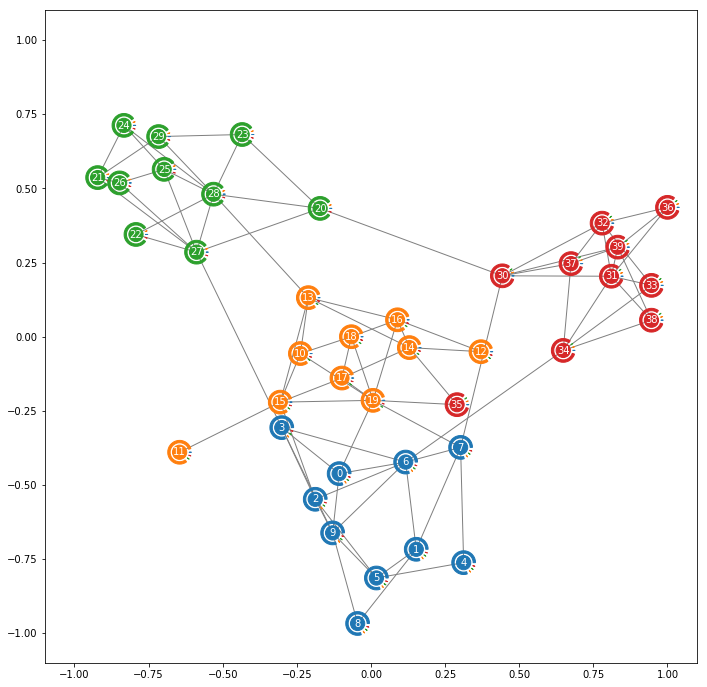

In [46]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [48]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.35225 train_acc=0.37500 val_loss=1.25581 val_acc=0.56250 time=0.04598
Epoch: 0002 train_loss=1.28302 train_acc=0.50000 val_loss=1.20332 val_acc=0.68750 time=0.00198
Epoch: 0003 train_loss=1.21463 train_acc=0.62500 val_loss=1.15361 val_acc=0.75000 time=0.00238
Epoch: 0004 train_loss=1.15080 train_acc=0.62500 val_loss=1.10611 val_acc=0.75000 time=0.00189
Epoch: 0005 train_loss=1.09078 train_acc=0.62500 val_loss=1.06029 val_acc=0.75000 time=0.01599
Epoch: 0006 train_loss=1.03379 train_acc=0.75000 val_loss=1.01608 val_acc=0.78125 time=0.00228
Epoch: 0007 train_loss=0.97967 train_acc=0.75000 val_loss=0.97343 val_acc=1.00000 time=0.00321
Epoch: 0008 train_loss=0.92838 train_acc=1.00000 val_loss=0.93231 val_acc=1.00000 time=0.00296
Epoch: 0009 train_loss=0.87977 train_acc=1.00000 val_loss=0.89298 val_acc=1.00000 time=0.00745
Epoch: 0010 train_loss=0.83411 train_acc=1.00000 val_loss=0.85523 val_acc=1.00000 time=0.00160
Epoch: 0011 train_loss=0.79097 train_acc=1.00000 v

Epoch: 0088 train_loss=0.02328 train_acc=1.00000 val_loss=0.10013 val_acc=0.96875 time=0.00220
Epoch: 0089 train_loss=0.02268 train_acc=1.00000 val_loss=0.09969 val_acc=0.96875 time=0.00156
Epoch: 0090 train_loss=0.02210 train_acc=1.00000 val_loss=0.09928 val_acc=0.96875 time=0.00179
Epoch: 0091 train_loss=0.02155 train_acc=1.00000 val_loss=0.09888 val_acc=0.96875 time=0.00202
Epoch: 0092 train_loss=0.02102 train_acc=1.00000 val_loss=0.09851 val_acc=0.96875 time=0.00231
Epoch: 0093 train_loss=0.02051 train_acc=1.00000 val_loss=0.09815 val_acc=0.96875 time=0.00182
Epoch: 0094 train_loss=0.02002 train_acc=1.00000 val_loss=0.09781 val_acc=0.96875 time=0.00245
Epoch: 0095 train_loss=0.01956 train_acc=1.00000 val_loss=0.09749 val_acc=0.96875 time=0.00203
Epoch: 0096 train_loss=0.01911 train_acc=1.00000 val_loss=0.09718 val_acc=0.96875 time=0.00276
Epoch: 0097 train_loss=0.01867 train_acc=1.00000 val_loss=0.09689 val_acc=0.96875 time=0.00541
Epoch: 0098 train_loss=0.01826 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = 1$

TODO: comment

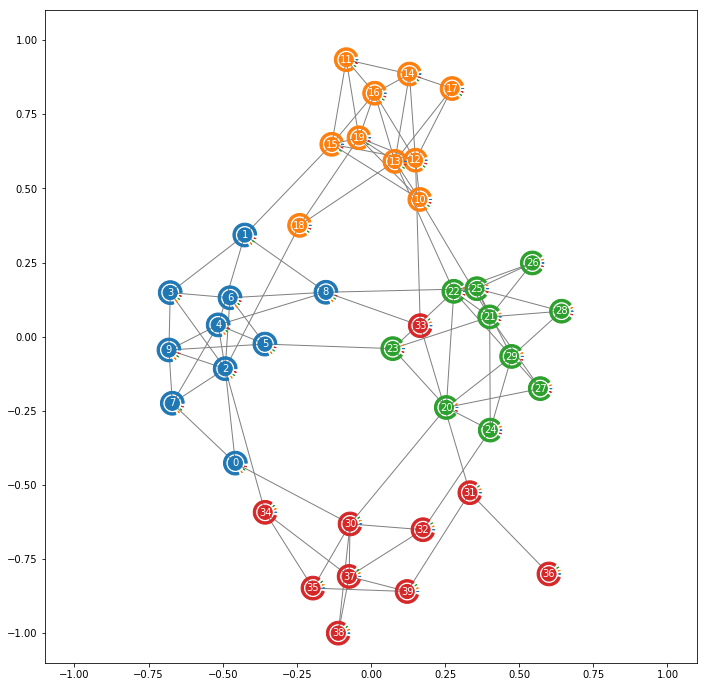

In [54]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [55]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.22224 train_acc=0.50000 val_loss=1.15582 val_acc=0.40625 time=0.05011
Epoch: 0002 train_loss=1.17270 train_acc=0.37500 val_loss=1.10027 val_acc=0.43750 time=0.00246
Epoch: 0003 train_loss=1.12877 train_acc=0.25000 val_loss=1.05311 val_acc=0.53125 time=0.00178
Epoch: 0004 train_loss=1.08965 train_acc=0.25000 val_loss=1.01288 val_acc=0.59375 time=0.00280
Epoch: 0005 train_loss=1.05492 train_acc=0.37500 val_loss=0.97842 val_acc=0.62500 time=0.00198
Epoch: 0006 train_loss=1.02391 train_acc=0.50000 val_loss=0.94857 val_acc=0.62500 time=0.00160
Epoch: 0007 train_loss=0.99639 train_acc=0.50000 val_loss=0.92233 val_acc=0.62500 time=0.00155
Epoch: 0008 train_loss=0.97135 train_acc=0.50000 val_loss=0.89876 val_acc=0.65625 time=0.00157
Epoch: 0009 train_loss=0.94805 train_acc=0.50000 val_loss=0.87734 val_acc=0.78125 time=0.00196
Epoch: 0010 train_loss=0.92633 train_acc=0.62500 val_loss=0.85757 val_acc=0.84375 time=0.00213
Epoch: 0011 train_loss=0.90583 train_acc=0.75000 v

Epoch: 0088 train_loss=0.12985 train_acc=1.00000 val_loss=0.15594 val_acc=0.96875 time=0.00144
Epoch: 0089 train_loss=0.12580 train_acc=1.00000 val_loss=0.15283 val_acc=0.96875 time=0.00204
Epoch: 0090 train_loss=0.12189 train_acc=1.00000 val_loss=0.14985 val_acc=0.96875 time=0.00267
Epoch: 0091 train_loss=0.11812 train_acc=1.00000 val_loss=0.14703 val_acc=0.96875 time=0.00157
Epoch: 0092 train_loss=0.11450 train_acc=1.00000 val_loss=0.14433 val_acc=0.96875 time=0.00188
Epoch: 0093 train_loss=0.11101 train_acc=1.00000 val_loss=0.14172 val_acc=0.96875 time=0.00154
Epoch: 0094 train_loss=0.10764 train_acc=1.00000 val_loss=0.13923 val_acc=0.96875 time=0.00191
Epoch: 0095 train_loss=0.10443 train_acc=1.00000 val_loss=0.13683 val_acc=0.96875 time=0.00167
Epoch: 0096 train_loss=0.10133 train_acc=1.00000 val_loss=0.13453 val_acc=0.96875 time=0.00196
Epoch: 0097 train_loss=0.09834 train_acc=1.00000 val_loss=0.13232 val_acc=0.96875 time=0.00192
Epoch: 0098 train_loss=0.09546 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01770 train_acc=1.00000 val_loss=0.07224 val_acc=0.96875 time=0.00227
Epoch: 0176 train_loss=0.01744 train_acc=1.00000 val_loss=0.07200 val_acc=0.96875 time=0.00154
Epoch: 0177 train_loss=0.01718 train_acc=1.00000 val_loss=0.07177 val_acc=0.96875 time=0.00154
Epoch: 0178 train_loss=0.01694 train_acc=1.00000 val_loss=0.07154 val_acc=0.96875 time=0.00152
Epoch: 0179 train_loss=0.01669 train_acc=1.00000 val_loss=0.07131 val_acc=0.96875 time=0.00159
Epoch: 0180 train_loss=0.01646 train_acc=1.00000 val_loss=0.07109 val_acc=0.96875 time=0.00195
Epoch: 0181 train_loss=0.01623 train_acc=1.00000 val_loss=0.07088 val_acc=0.96875 time=0.00211
Epoch: 0182 train_loss=0.01600 train_acc=1.00000 val_loss=0.07067 val_acc=0.96875 time=0.00156
Epoch: 0183 train_loss=0.01578 train_acc=1.00000 val_loss=0.07046 val_acc=0.96875 time=0.00182
Epoch: 0184 train_loss=0.01557 train_acc=1.00000 val_loss=0.07026 val_acc=0.96875 time=0.00203
Epoch: 0185 train_loss=0.01535 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = 1$, with 5 samplings

Here, instead of simply using $X_i \sim Y_i + \mathcal{N}(0, \sigma^2)$, we draw 5 such samples for each coordinate in the "real" label $Y_i$:

$$X_{i, 5 \cdot (j-1) + k} = Y_{i, j} + \mathcal{N}(0, \sigma^2) \quad k \in \{1, \dots, 5\}$$

This tests if the GCN can take advantage of the redundancy to recover the communities in spite of the strong noise ($\sigma = 1$).

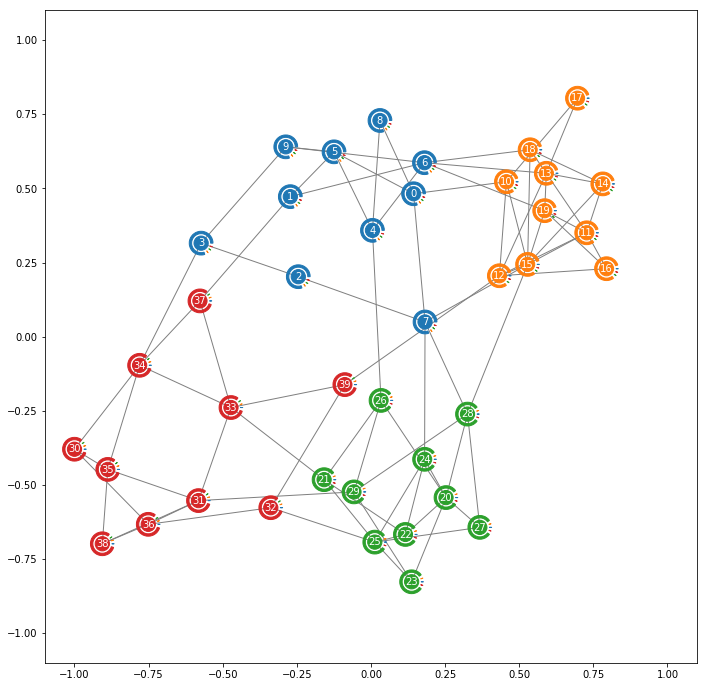

In [59]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 5
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [61]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.55289 train_acc=0.00000 val_loss=1.41451 val_acc=0.28125 time=0.05472
Epoch: 0002 train_loss=1.34947 train_acc=0.37500 val_loss=1.24475 val_acc=0.50000 time=0.00198
Epoch: 0003 train_loss=1.21119 train_acc=0.62500 val_loss=1.19272 val_acc=0.62500 time=0.00185
Epoch: 0004 train_loss=1.13090 train_acc=0.62500 val_loss=1.17565 val_acc=0.62500 time=0.00191
Epoch: 0005 train_loss=1.08561 train_acc=0.62500 val_loss=1.16322 val_acc=0.62500 time=0.00177
Epoch: 0006 train_loss=1.05247 train_acc=0.62500 val_loss=1.14666 val_acc=0.62500 time=0.00182
Epoch: 0007 train_loss=1.02124 train_acc=0.62500 val_loss=1.12377 val_acc=0.62500 time=0.00644
Epoch: 0008 train_loss=0.98715 train_acc=0.62500 val_loss=1.09531 val_acc=0.62500 time=0.00168
Epoch: 0009 train_loss=0.95071 train_acc=0.62500 val_loss=1.06348 val_acc=0.62500 time=0.00210
Epoch: 0010 train_loss=0.91224 train_acc=0.62500 val_loss=1.03065 val_acc=0.62500 time=0.00172
Epoch: 0011 train_loss=0.87410 train_acc=0.62500 v

Epoch: 0088 train_loss=0.01732 train_acc=1.00000 val_loss=0.26554 val_acc=0.93750 time=0.00185
Epoch: 0089 train_loss=0.01684 train_acc=1.00000 val_loss=0.26437 val_acc=0.93750 time=0.00168
Epoch: 0090 train_loss=0.01638 train_acc=1.00000 val_loss=0.26322 val_acc=0.93750 time=0.00172
Epoch: 0091 train_loss=0.01594 train_acc=1.00000 val_loss=0.26200 val_acc=0.93750 time=0.00246
Epoch: 0092 train_loss=0.01553 train_acc=1.00000 val_loss=0.26068 val_acc=0.93750 time=0.00198
Epoch: 0093 train_loss=0.01513 train_acc=1.00000 val_loss=0.25923 val_acc=0.93750 time=0.00173
Epoch: 0094 train_loss=0.01475 train_acc=1.00000 val_loss=0.25770 val_acc=0.93750 time=0.00163
Epoch: 0095 train_loss=0.01439 train_acc=1.00000 val_loss=0.25614 val_acc=0.93750 time=0.00180
Epoch: 0096 train_loss=0.01405 train_acc=1.00000 val_loss=0.25465 val_acc=0.93750 time=0.00172
Epoch: 0097 train_loss=0.01372 train_acc=1.00000 val_loss=0.25325 val_acc=0.93750 time=0.00169
Epoch: 0098 train_loss=0.01340 train_acc=1.00000 v

Epoch: 0175 train_loss=0.00436 train_acc=1.00000 val_loss=0.21120 val_acc=0.93750 time=0.00248
Epoch: 0176 train_loss=0.00431 train_acc=1.00000 val_loss=0.21094 val_acc=0.93750 time=0.00242
Epoch: 0177 train_loss=0.00427 train_acc=1.00000 val_loss=0.21068 val_acc=0.93750 time=0.00228
Epoch: 0178 train_loss=0.00423 train_acc=1.00000 val_loss=0.21041 val_acc=0.93750 time=0.00167
Epoch: 0179 train_loss=0.00418 train_acc=1.00000 val_loss=0.21013 val_acc=0.96875 time=0.00202
Epoch: 0180 train_loss=0.00414 train_acc=1.00000 val_loss=0.20984 val_acc=0.96875 time=0.00214
Epoch: 0181 train_loss=0.00410 train_acc=1.00000 val_loss=0.20955 val_acc=0.96875 time=0.00267
Epoch: 0182 train_loss=0.00406 train_acc=1.00000 val_loss=0.20927 val_acc=0.96875 time=0.00168
Epoch: 0183 train_loss=0.00402 train_acc=1.00000 val_loss=0.20900 val_acc=0.96875 time=0.00201
Epoch: 0184 train_loss=0.00398 train_acc=1.00000 val_loss=0.20874 val_acc=0.96875 time=0.00178
Epoch: 0185 train_loss=0.00394 train_acc=1.00000 v

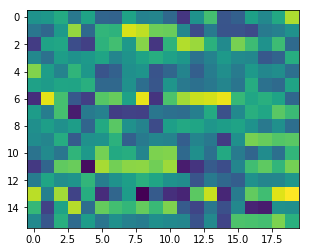

In [79]:
plt.imshow(model.layers[0].vars['weights_0'].eval(session=session).T)

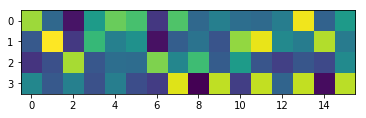

In [78]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T)

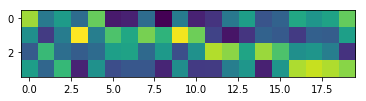

In [80]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T
           .dot(model.layers[0].vars['weights_0'].eval(session=session).T))

#### Four well-marked communities of size 10; $\sigma = 100$

TODO: comment

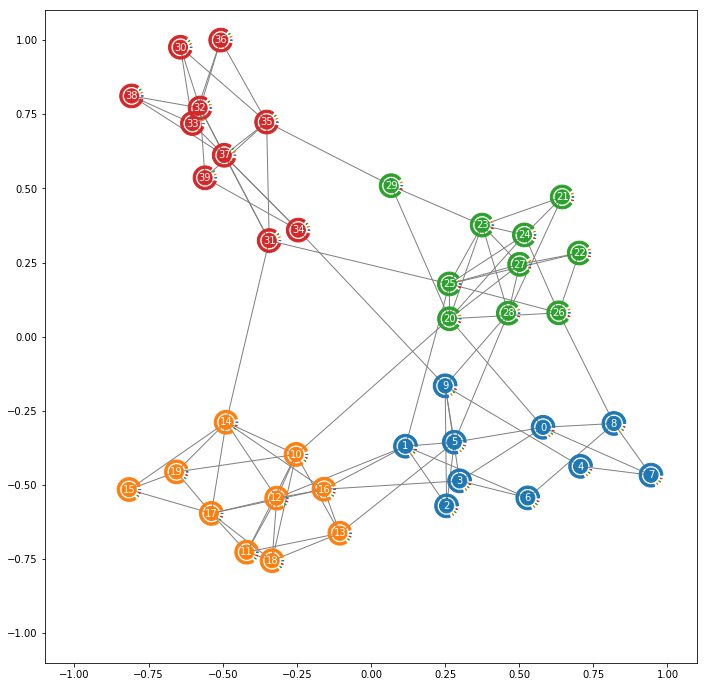

In [81]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 100

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [82]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.82797 train_acc=0.25000 val_loss=1.80970 val_acc=0.28125 time=0.06039
Epoch: 0002 train_loss=1.72969 train_acc=0.25000 val_loss=1.70022 val_acc=0.28125 time=0.00169
Epoch: 0003 train_loss=1.64115 train_acc=0.25000 val_loss=1.60123 val_acc=0.28125 time=0.00172
Epoch: 0004 train_loss=1.56193 train_acc=0.25000 val_loss=1.51022 val_acc=0.28125 time=0.00188
Epoch: 0005 train_loss=1.48871 train_acc=0.25000 val_loss=1.42694 val_acc=0.28125 time=0.00163
Epoch: 0006 train_loss=1.42117 train_acc=0.25000 val_loss=1.35276 val_acc=0.25000 time=0.00158
Epoch: 0007 train_loss=1.36063 train_acc=0.25000 val_loss=1.28797 val_acc=0.34375 time=0.00227
Epoch: 0008 train_loss=1.30535 train_acc=0.25000 val_loss=1.23330 val_acc=0.50000 time=0.00159
Epoch: 0009 train_loss=1.25503 train_acc=0.50000 val_loss=1.18820 val_acc=0.43750 time=0.00188
Epoch: 0010 train_loss=1.20931 train_acc=0.50000 val_loss=1.15237 val_acc=0.43750 time=0.00187
Epoch: 0011 train_loss=1.16840 train_acc=0.50000 v

Epoch: 0088 train_loss=0.27185 train_acc=1.00000 val_loss=0.63160 val_acc=0.87500 time=0.00570
Epoch: 0089 train_loss=0.26613 train_acc=1.00000 val_loss=0.62976 val_acc=0.87500 time=0.00458
Epoch: 0090 train_loss=0.26057 train_acc=1.00000 val_loss=0.62807 val_acc=0.87500 time=0.00195
Epoch: 0091 train_loss=0.25518 train_acc=1.00000 val_loss=0.62656 val_acc=0.87500 time=0.00197
Epoch: 0092 train_loss=0.24994 train_acc=1.00000 val_loss=0.62521 val_acc=0.87500 time=0.00361
Epoch: 0093 train_loss=0.24486 train_acc=1.00000 val_loss=0.62402 val_acc=0.87500 time=0.00227
Epoch: 0094 train_loss=0.23992 train_acc=1.00000 val_loss=0.62297 val_acc=0.87500 time=0.00248
Epoch: 0095 train_loss=0.23513 train_acc=1.00000 val_loss=0.62207 val_acc=0.87500 time=0.00153
Epoch: 0096 train_loss=0.23047 train_acc=1.00000 val_loss=0.62129 val_acc=0.87500 time=0.00164
Epoch: 0097 train_loss=0.22595 train_acc=1.00000 val_loss=0.62069 val_acc=0.87500 time=0.00224
Epoch: 0098 train_loss=0.22180 train_acc=1.00000 v

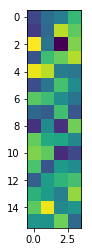

In [83]:
plt.imshow(model.layers[0].vars['weights_0'].eval(session=session).T)

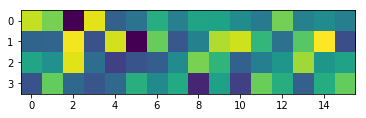

In [84]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T)

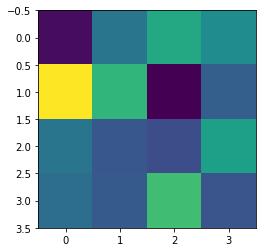

In [85]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T
           .dot(model.layers[0].vars['weights_0'].eval(session=session).T))

#### Five well-marked communities of size 20; $\sigma = 1$

TODO: comment

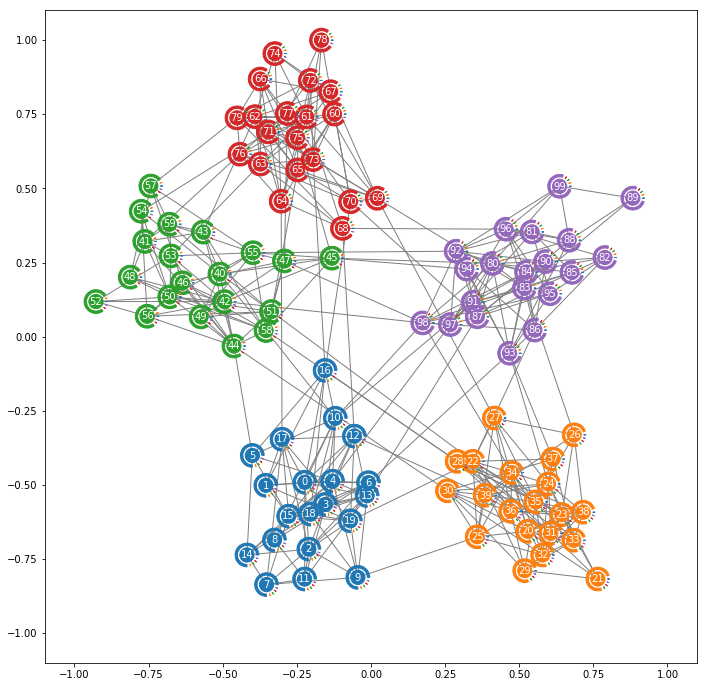

In [89]:
# Parameters
l = 5
k = 20
p_inner = .4
p_outer = .01
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [90]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=2.49388 train_acc=0.20000 val_loss=1.82893 val_acc=0.26250 time=0.06594
Epoch: 0002 train_loss=2.12870 train_acc=0.20000 val_loss=1.62115 val_acc=0.26250 time=0.00241
Epoch: 0003 train_loss=1.76819 train_acc=0.20000 val_loss=1.45748 val_acc=0.26250 time=0.00269
Epoch: 0004 train_loss=1.45910 train_acc=0.20000 val_loss=1.37911 val_acc=0.43750 time=0.00231
Epoch: 0005 train_loss=1.30364 train_acc=0.40000 val_loss=1.26449 val_acc=0.46250 time=0.00209
Epoch: 0006 train_loss=1.19156 train_acc=0.40000 val_loss=1.18244 val_acc=0.46250 time=0.00390
Epoch: 0007 train_loss=1.13577 train_acc=0.40000 val_loss=1.13508 val_acc=0.47500 time=0.00196
Epoch: 0008 train_loss=1.11269 train_acc=0.45000 val_loss=1.09903 val_acc=0.48750 time=0.00352
Epoch: 0009 train_loss=1.08939 train_acc=0.45000 val_loss=1.06602 val_acc=0.50000 time=0.00221
Epoch: 0010 train_loss=1.05769 train_acc=0.45000 val_loss=1.03595 val_acc=0.51250 time=0.00223
Epoch: 0011 train_loss=1.02037 train_acc=0.45000 v

Epoch: 0088 train_loss=0.09900 train_acc=1.00000 val_loss=0.24954 val_acc=0.95000 time=0.00189
Epoch: 0089 train_loss=0.09728 train_acc=1.00000 val_loss=0.24809 val_acc=0.95000 time=0.00249
Epoch: 0090 train_loss=0.09560 train_acc=1.00000 val_loss=0.24680 val_acc=0.95000 time=0.00234
Epoch: 0091 train_loss=0.09398 train_acc=1.00000 val_loss=0.24567 val_acc=0.95000 time=0.00195
Epoch: 0092 train_loss=0.09241 train_acc=1.00000 val_loss=0.24461 val_acc=0.95000 time=0.00237
Epoch: 0093 train_loss=0.09089 train_acc=1.00000 val_loss=0.24357 val_acc=0.95000 time=0.00230
Epoch: 0094 train_loss=0.08940 train_acc=1.00000 val_loss=0.24251 val_acc=0.95000 time=0.00194
Epoch: 0095 train_loss=0.08796 train_acc=1.00000 val_loss=0.24139 val_acc=0.95000 time=0.00197
Epoch: 0096 train_loss=0.08655 train_acc=1.00000 val_loss=0.24025 val_acc=0.95000 time=0.00240
Epoch: 0097 train_loss=0.08519 train_acc=1.00000 val_loss=0.23945 val_acc=0.95000 time=0.00188
Epoch: 0098 train_loss=0.08397 train_acc=1.00000 v

Epoch: 0175 train_loss=0.03248 train_acc=1.00000 val_loss=0.20156 val_acc=0.92500 time=0.00221
Epoch: 0176 train_loss=0.03214 train_acc=1.00000 val_loss=0.20144 val_acc=0.92500 time=0.00227
Epoch: 0177 train_loss=0.03181 train_acc=1.00000 val_loss=0.20126 val_acc=0.92500 time=0.00240
Epoch: 0178 train_loss=0.03148 train_acc=1.00000 val_loss=0.20101 val_acc=0.92500 time=0.00230
Epoch: 0179 train_loss=0.03116 train_acc=1.00000 val_loss=0.20080 val_acc=0.92500 time=0.00192
Epoch: 0180 train_loss=0.03084 train_acc=1.00000 val_loss=0.20063 val_acc=0.92500 time=0.00253
Epoch: 0181 train_loss=0.03052 train_acc=1.00000 val_loss=0.20046 val_acc=0.92500 time=0.00195
Epoch: 0182 train_loss=0.03021 train_acc=1.00000 val_loss=0.20029 val_acc=0.92500 time=0.00201
Epoch: 0183 train_loss=0.02990 train_acc=1.00000 val_loss=0.20003 val_acc=0.92500 time=0.00231
Epoch: 0184 train_loss=0.02960 train_acc=1.00000 val_loss=0.19978 val_acc=0.92500 time=0.00230
Epoch: 0185 train_loss=0.02930 train_acc=1.00000 v

#### Four poorly-marked communities of size 100; $\sigma = 1$

This is useless as we can't see a thing in the animation, but it was worth a try.

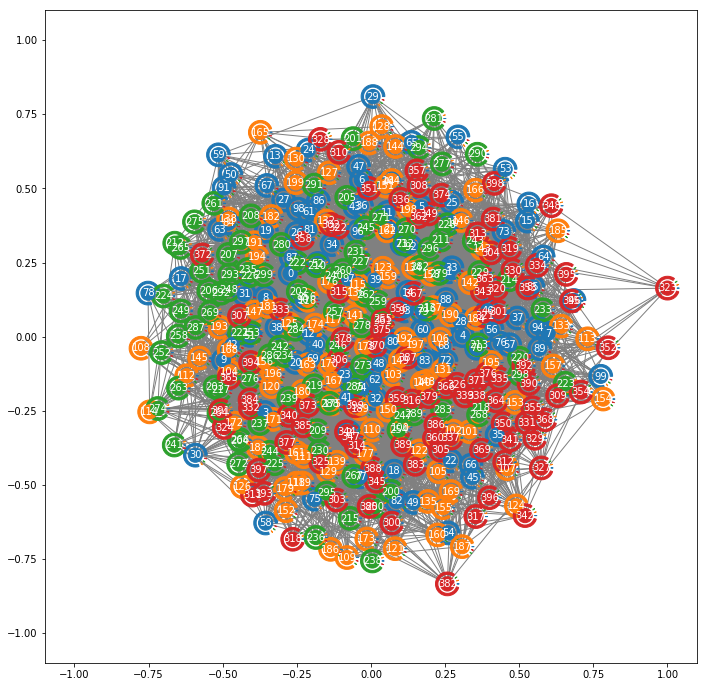

In [91]:
# Parameters
l = 4
k = 100
p_inner = .1
p_outer = .05
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [92]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.49156 train_acc=0.26250 val_loss=1.48697 val_acc=0.24375 time=0.07263
Epoch: 0002 train_loss=1.44695 train_acc=0.22500 val_loss=1.45169 val_acc=0.25000 time=0.00467
Epoch: 0003 train_loss=1.41081 train_acc=0.21250 val_loss=1.42511 val_acc=0.25313 time=0.00470
Epoch: 0004 train_loss=1.38379 train_acc=0.22500 val_loss=1.40719 val_acc=0.25000 time=0.00536
Epoch: 0005 train_loss=1.36629 train_acc=0.25000 val_loss=1.39734 val_acc=0.26562 time=0.00570
Epoch: 0006 train_loss=1.35790 train_acc=0.25000 val_loss=1.39418 val_acc=0.26875 time=0.00487
Epoch: 0007 train_loss=1.35668 train_acc=0.28750 val_loss=1.39529 val_acc=0.26562 time=0.00527
Epoch: 0008 train_loss=1.35934 train_acc=0.28750 val_loss=1.39797 val_acc=0.27812 time=0.00450
Epoch: 0009 train_loss=1.36267 train_acc=0.33750 val_loss=1.40013 val_acc=0.25938 time=0.00587
Epoch: 0010 train_loss=1.36442 train_acc=0.33750 val_loss=1.40081 val_acc=0.25625 time=0.00527
Epoch: 0011 train_loss=1.36390 train_acc=0.33750 v

Epoch: 0088 train_loss=1.18960 train_acc=0.47500 val_loss=1.32960 val_acc=0.40000 time=0.00511
Epoch: 0089 train_loss=1.18732 train_acc=0.47500 val_loss=1.32935 val_acc=0.40000 time=0.00514
Epoch: 0090 train_loss=1.18508 train_acc=0.48750 val_loss=1.32911 val_acc=0.39687 time=0.00522
Epoch: 0091 train_loss=1.18286 train_acc=0.48750 val_loss=1.32889 val_acc=0.39687 time=0.00606
Epoch: 0092 train_loss=1.18059 train_acc=0.48750 val_loss=1.32867 val_acc=0.40000 time=0.00521
Epoch: 0093 train_loss=1.17830 train_acc=0.48750 val_loss=1.32856 val_acc=0.39687 time=0.00471
Epoch: 0094 train_loss=1.17610 train_acc=0.48750 val_loss=1.32848 val_acc=0.39375 time=0.00562
Epoch: 0095 train_loss=1.17401 train_acc=0.48750 val_loss=1.32832 val_acc=0.39375 time=0.00551
Epoch: 0096 train_loss=1.17190 train_acc=0.50000 val_loss=1.32805 val_acc=0.39375 time=0.00494
Epoch: 0097 train_loss=1.16990 train_acc=0.50000 val_loss=1.32777 val_acc=0.39687 time=0.00519
Epoch: 0098 train_loss=1.16794 train_acc=0.50000 v

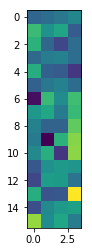

In [98]:
plt.imshow(model.layers[0].vars['weights_0'].eval(session=session).T)

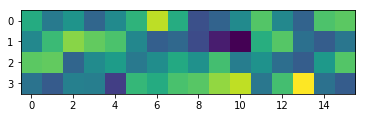

In [99]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T)

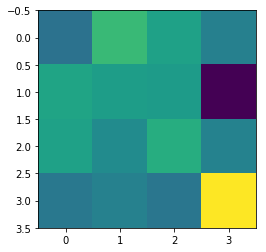

In [100]:
plt.imshow(model.layers[1].vars['weights_0'].eval(session=session).T
           .dot(model.layers[0].vars['weights_0'].eval(session=session).T))